In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
CSV_FILENAME = 'style_transfer_experiment2_log.csv'
try:
    df_log = pd.read_csv(CSV_FILENAME)
except FileNotFoundError:
    print(f"Error: '{CSV_FILENAME}' not found. Please ensure the file exists in the current directory or provide the full path.")
    exit()

print("Successfully loaded the experimental data. Here's a preview:")
print(df_log.head())
print(f"\nShape of the data: {df_log.shape}")
print("\nColumns in the data:")
print(df_log.columns.tolist())
print("\nBasic descriptive statistics for numerical columns:")
print(df_log.describe())
JSON_FILENAME = 'style_transfer_experiment_log.json'
if not df_log.empty:
    try:
        # orient='records' creates a list of JSON objects, one for each row.
        # This is a common and useful format for JSON data.
        # indent=4 makes the JSON file human-readable (pretty-printed).
        df_log.to_json(JSON_FILENAME, orient='records', indent=4)
        print(f"\nSuccessfully saved the data to '{JSON_FILENAME}'")
    except Exception as e:
        print(f"\nError saving data to JSON: {e}")
else:
    print("\nDataFrame is empty. Cannot save to JSON.")


Successfully loaded the experimental data. Here's a preview:
                                         config_name     timestamp  \
0  webcam_steps10_imsize256_styleW1e+06_contentW1...  1.748459e+09   
1  webcam_steps10_imsize256_styleW1e+06_contentW1...  1.748459e+09   
2  webcam_steps10_imsize256_styleW1e+06_contentW1...  1.748459e+09   
3  webcam_steps10_imsize256_styleW1e+06_contentW1...  1.748459e+09   
4  webcam_steps10_imsize256_styleW1e+06_contentW1...  1.748459e+09   

   num_steps_config  imsize_config  style_weight_config  \
0                10            256            1000000.0   
1                10            256            1000000.0   
2                10            256            1000000.0   
3                10            256            1000000.0   
4                10            256            1000000.0   

   content_weight_config                                  style_image_path  \
0                      1  Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg   
1      

In [3]:
# Table 1: Summary statistics grouped by key experimental parameters.
# This table will show average performance (FPS, loop time) and average final losses
# for each unique combination of 'num_steps_config', 'imsize_config', and 'style_weight_config'.
print("\n--- Generating Summary Table ---")
if not df_log.empty:
    # Define the columns to group by and the metrics to aggregate
    grouping_columns = ['num_steps_config', 'imsize_config', 'style_weight_config', 'content_weight_config']
    
    # Ensure all grouping columns exist
    missing_cols = [col for col in grouping_columns if col not in df_log.columns]
    if missing_cols:
        print(f"Warning: Missing columns for grouping: {missing_cols}. Adjusting grouping_columns.")
        grouping_columns = [col for col in grouping_columns if col in df_log.columns]

    if grouping_columns: # Proceed if there are valid columns to group by
        summary_table = df_log.groupby(grouping_columns).agg(
            avg_loop_time_s=('loop_time_s', 'mean'),
            std_loop_time_s=('loop_time_s', 'std'),
            avg_fps=('fps_calculated', 'mean'),
            std_fps=('fps_calculated', 'std'),
            avg_style_loss=('final_weighted_style_loss', 'mean'),
            avg_content_loss=('final_weighted_content_loss', 'mean'),
            num_frames_logged=('timestamp', 'count') # Count of logged entries for this config
        ).reset_index()

        # Round numerical values for better presentation
        summary_table = summary_table.round({
            'avg_loop_time_s': 3, 'std_loop_time_s': 3,
            'avg_fps': 2, 'std_fps': 2,
            'avg_style_loss': 2, 'avg_content_loss': 2
        })

        print("\nSummary Table of Experimental Results:")
        print(summary_table)

        # Save the summary table to a CSV file (good for importing into Word/Excel/LaTeX)
        summary_table_filename = 'experiment_summary_table.csv'
        summary_table.to_csv(summary_table_filename, index=False)
        print(f"\nSummary table saved to '{summary_table_filename}'")

        # For direct LaTeX output (optional):
        # print("\nLaTeX format of the summary table:")
        # print(summary_table.to_latex(index=False, float_format="%.2f"))
    else:
        print("No valid columns found for grouping. Cannot generate summary table.")
else:
    print("DataFrame is empty. No data to process for tables.")


--- Generating Summary Table ---

Summary Table of Experimental Results:
   num_steps_config  imsize_config  style_weight_config  \
0                10            256            1000000.0   
1               200            256            1000000.0   

   content_weight_config  avg_loop_time_s  std_loop_time_s  avg_fps  std_fps  \
0                      1            0.377            0.097     2.49     0.57   
1                      1           10.133            0.409     0.10     0.00   

   avg_style_loss  avg_content_loss  num_frames_logged  
0         1033.46             28.81                 32  
1            7.35             22.94                 10  

Summary table saved to 'experiment_summary_table.csv'



--- Generating Graphs ---
Saved 'fps_vs_num_steps.png'
Saved 'loop_time_vs_num_steps.png'
Saved 'style_loss_vs_num_steps.png'
Saved 'content_loss_vs_num_steps.png'


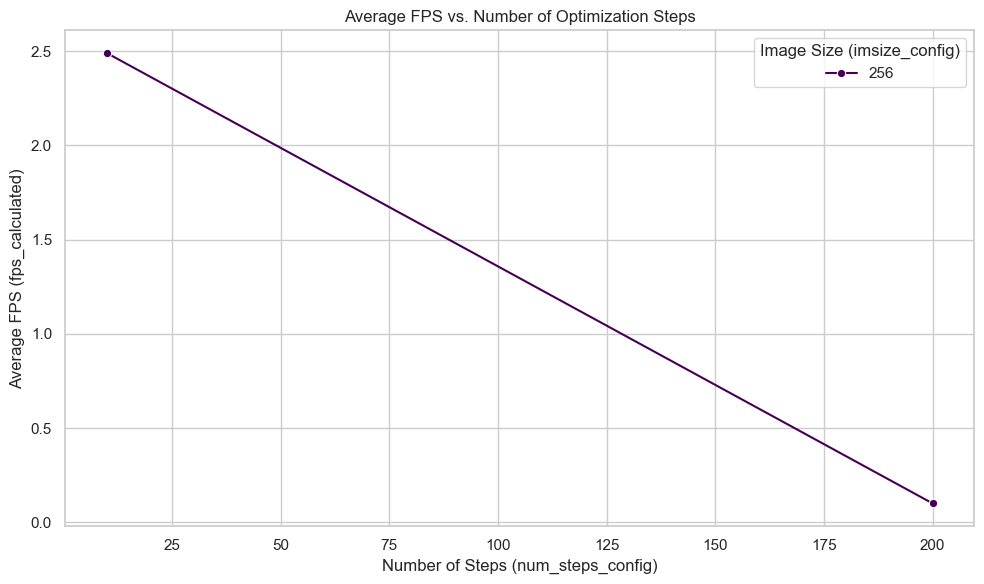

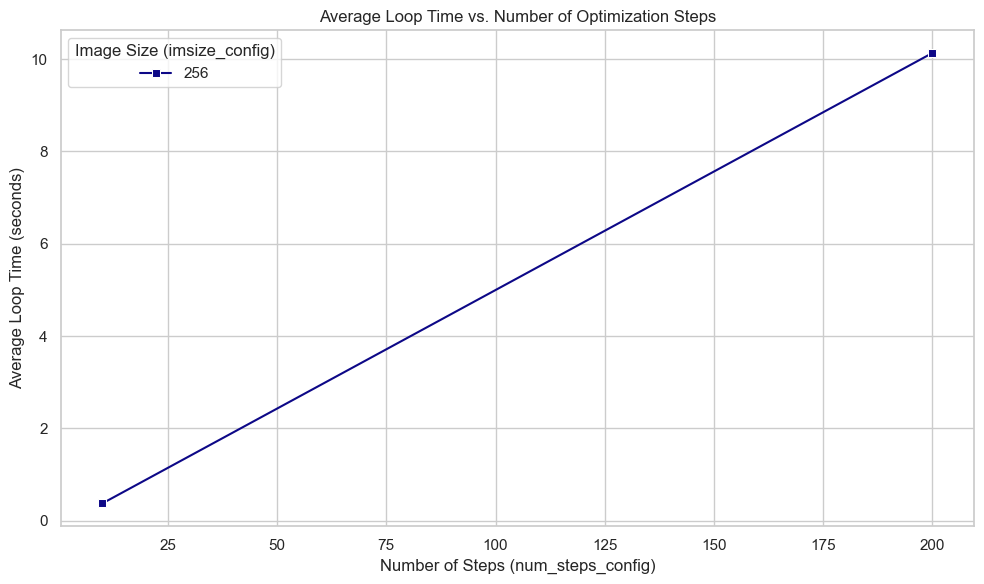

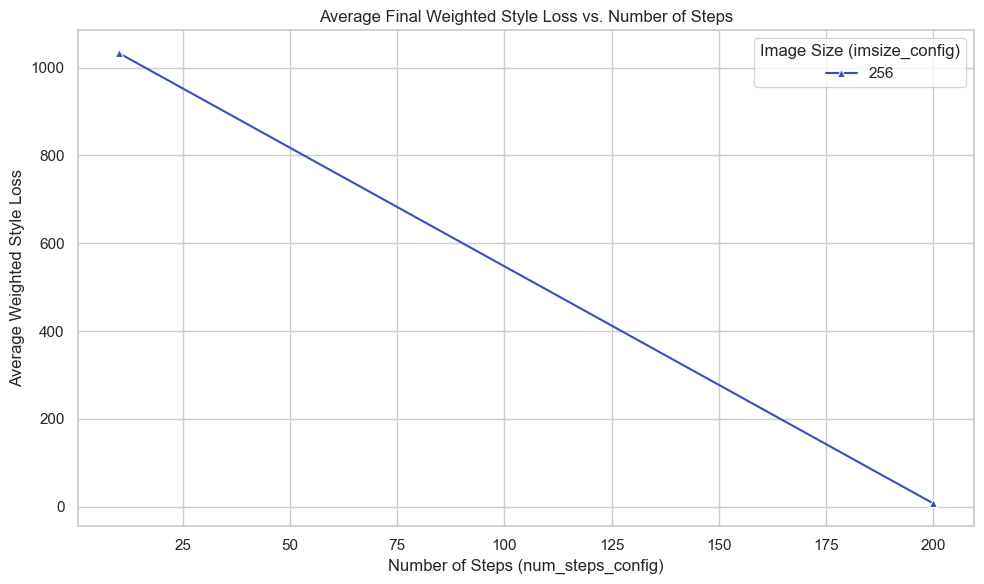

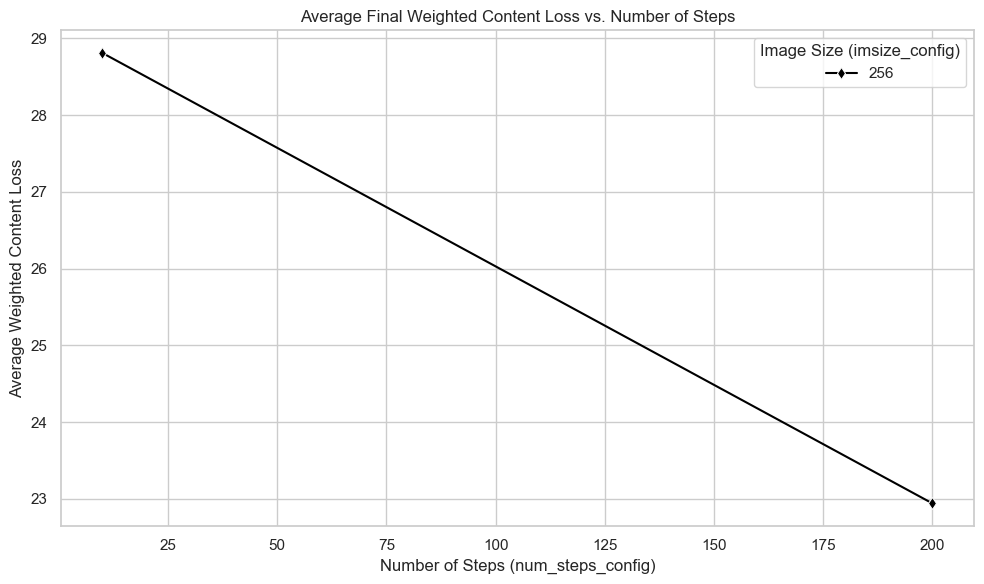

In [4]:
print("\n--- Generating Graphs ---")

if not df_log.empty:
    # Set a nice plotting style
    sns.set_theme(style="whitegrid", palette="muted")
    plt.rcParams['figure.figsize'] = (10, 6)
    plt.rcParams['font.size'] = 12

    # Ensure there are unique values to plot against for 'num_steps_config'
    if 'num_steps_config' in df_log.columns and df_log['num_steps_config'].nunique() > 1:

        # Plot 1: Average FPS vs. Number of Steps, grouped by image size
        # We'll use the summary_table if it was generated, otherwise aggregate directly from df_log
        plot_df_fps_steps = summary_table if 'summary_table' in locals() and not summary_table.empty else \
                            df_log.groupby(['num_steps_config', 'imsize_config']).agg(avg_fps=('fps_calculated', 'mean')).reset_index()
        
        if not plot_df_fps_steps.empty:
            plt.figure()
            sns.lineplot(data=plot_df_fps_steps, x='num_steps_config', y='avg_fps', hue='imsize_config', marker='o', palette='viridis')
            plt.title('Average FPS vs. Number of Optimization Steps')
            plt.xlabel('Number of Steps (num_steps_config)')
            plt.ylabel('Average FPS (fps_calculated)')
            plt.legend(title='Image Size (imsize_config)')
            plt.tight_layout()
            plt.savefig('fps_vs_num_steps.png', dpi=300)
            print("Saved 'fps_vs_num_steps.png'")
            # plt.show() # Uncomment to display plot if running interactively

        # Plot 2: Average Loop Time vs. Number of Steps, grouped by image size
        plot_df_loop_steps = summary_table if 'summary_table' in locals() and not summary_table.empty else \
                             df_log.groupby(['num_steps_config', 'imsize_config']).agg(avg_loop_time_s=('loop_time_s', 'mean')).reset_index()

        if not plot_df_loop_steps.empty:
            plt.figure()
            sns.lineplot(data=plot_df_loop_steps, x='num_steps_config', y='avg_loop_time_s', hue='imsize_config', marker='s', palette='plasma')
            plt.title('Average Loop Time vs. Number of Optimization Steps')
            plt.xlabel('Number of Steps (num_steps_config)')
            plt.ylabel('Average Loop Time (seconds)')
            plt.legend(title='Image Size (imsize_config)')
            plt.tight_layout()
            plt.savefig('loop_time_vs_num_steps.png', dpi=300)
            print("Saved 'loop_time_vs_num_steps.png'")
            # plt.show()

        # Plot 3: Average Final Weighted Style Loss vs. Number of Steps
        plot_df_style_loss_steps = summary_table if 'summary_table' in locals() and not summary_table.empty else \
                                   df_log.groupby(['num_steps_config', 'imsize_config']).agg(avg_style_loss=('final_weighted_style_loss', 'mean')).reset_index()
        
        if not plot_df_style_loss_steps.empty:
            plt.figure()
            sns.lineplot(data=plot_df_style_loss_steps, x='num_steps_config', y='avg_style_loss', hue='imsize_config', marker='^', palette='coolwarm')
            plt.title('Average Final Weighted Style Loss vs. Number of Steps')
            plt.xlabel('Number of Steps (num_steps_config)')
            plt.ylabel('Average Weighted Style Loss')
            plt.legend(title='Image Size (imsize_config)')
            # plt.yscale('log') # Consider log scale if losses vary greatly
            plt.tight_layout()
            plt.savefig('style_loss_vs_num_steps.png', dpi=300)
            print("Saved 'style_loss_vs_num_steps.png'")
            # plt.show()

        # Plot 4: Average Final Weighted Content Loss vs. Number of Steps
        plot_df_content_loss_steps = summary_table if 'summary_table' in locals() and not summary_table.empty else \
                                     df_log.groupby(['num_steps_config', 'imsize_config']).agg(avg_content_loss=('final_weighted_content_loss', 'mean')).reset_index()

        if not plot_df_content_loss_steps.empty:
            plt.figure()
            sns.lineplot(data=plot_df_content_loss_steps, x='num_steps_config', y='avg_content_loss', hue='imsize_config', marker='d', palette='cubehelix')
            plt.title('Average Final Weighted Content Loss vs. Number of Steps')
            plt.xlabel('Number of Steps (num_steps_config)')
            plt.ylabel('Average Weighted Content Loss')
            plt.legend(title='Image Size (imsize_config)')
            plt.tight_layout()
            plt.savefig('content_loss_vs_num_steps.png', dpi=300)
            print("Saved 'content_loss_vs_num_steps.png'")
            # plt.show()
    else:
        print("Not enough variation in 'num_steps_config' to generate step-based line plots, or column missing.")


Saved 'loss_tradeoff_scatter.png'
Saved 'avg_convergence_points_vs_steps.png'

Graph generation complete. Check for .png files in your current directory.


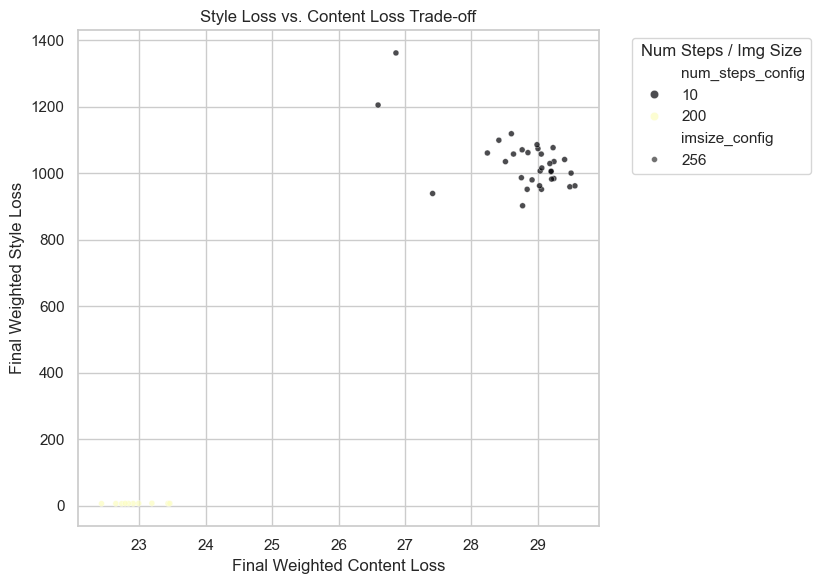

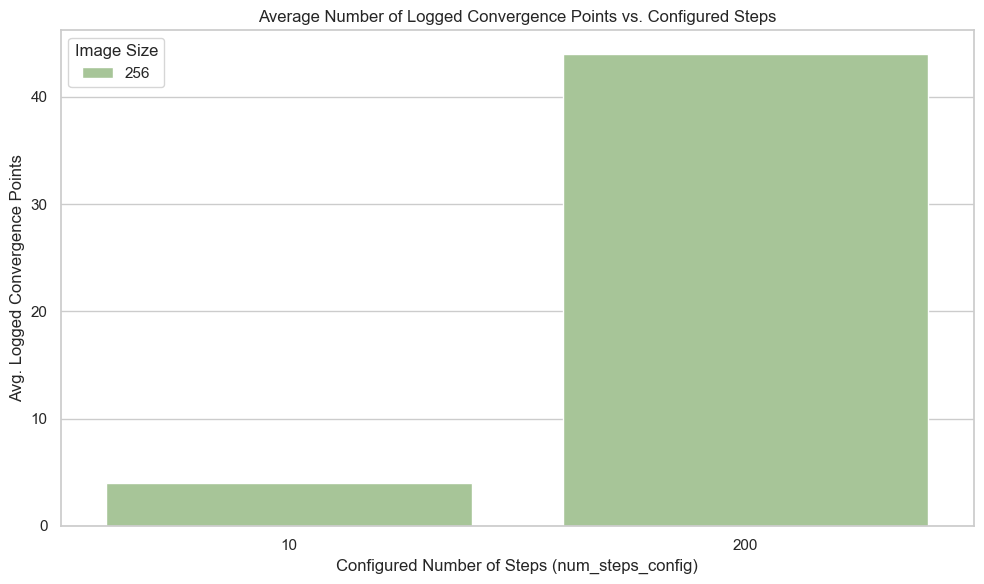

In [16]:
# --- Plotting Style vs. Content Loss Trade-off ---
if all(col in df_log.columns for col in ['final_weighted_style_loss', 'final_weighted_content_loss', 'num_steps_config', 'imsize_config']):
    plt.figure()
    sns.scatterplot(
        data=df_log,
        x='final_weighted_content_loss',
        y='final_weighted_style_loss',
        hue='num_steps_config',
        size='imsize_config',
        palette='magma',
        legend='full',
        alpha=0.7
    )
    plt.title('Style Loss vs. Content Loss Trade-off')
    plt.xlabel('Final Weighted Content Loss')
    plt.ylabel('Final Weighted Style Loss')
    plt.legend(title='Num Steps / Img Size', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.savefig('loss_tradeoff_scatter.png', dpi=300)
    print("Saved 'loss_tradeoff_scatter.png'")
else:
    print("Missing columns for loss trade-off scatter plot. Required: 'final_weighted_style_loss', 'final_weighted_content_loss', 'num_steps_config', 'imsize_config'.")

# --- Plotting Convergence Data (if logged and desired) ---
required_cols_conv_plot = ['convergence_detail_steps', 'num_steps_config', 'imsize_config']
if all(col in df_log.columns for col in required_cols_conv_plot):
    # Use summary_table if it has 'avg_conv_detail_steps' and is not empty, otherwise compute.
    if not summary_table.empty and 'avg_conv_detail_steps' in summary_table.columns:
        plot_df_conv_steps = summary_table[summary_table['avg_conv_detail_steps'].notna()]
    else:
        # Fallback if summary_table didn't include the column
        plot_df_conv_steps = df_log.groupby(['num_steps_config', 'imsize_config'], as_index=False).agg(
            avg_conv_detail_steps=('convergence_detail_steps', 'mean')
        )

    if not plot_df_conv_steps.empty:
        plt.figure()
        sns.barplot(
            data=plot_df_conv_steps,
            x='num_steps_config',
            y='avg_conv_detail_steps',
            hue='imsize_config',
            palette='crest',
            dodge=True
        )
        plt.title('Average Number of Logged Convergence Points vs. Configured Steps')
        plt.xlabel('Configured Number of Steps (num_steps_config)')
        plt.ylabel('Avg. Logged Convergence Points')
        plt.legend(title='Image Size')
        plt.tight_layout()
        plt.savefig('avg_convergence_points_vs_steps.png', dpi=300)
        print("Saved 'avg_convergence_points_vs_steps.png'")
    else:
        print("Could not generate data for convergence points plot.")
else:
    print(f"Missing one or more required columns for convergence plot: {required_cols_conv_plot}. Cannot generate.")

print("\nGraph generation complete. Check for .png files in your current directory.")
